### Import packages and data

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  19.1M      0  0:00:04  0:00:04 --:--:-- 19.1M


In [4]:
!ls aclImdb/

imdbEr.txt  imdb.vocab	README	test  train


#### The subfolers pos and neg contain respectively positive and negative feedbacks

In [5]:
!ls aclImdb/train/

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [6]:
!cat aclImdb/train/pos/1_7.txt

If you like adult comedy cartoons, like South Park, then this is nearly a similar format about the small adventures of three teenage girls at Bromwell High. Keisha, Natella and Latrina have given exploding sweets and behaved like bitches, I think Keisha is a good leader. There are also small stories going on with the teachers of the school. There's the idiotic principal, Mr. Bip, the nervous Maths teacher and many others. The cast is also fantastic, Lenny Henry's Gina Yashere, EastEnders Chrissie Watts, Tracy-Ann Oberman, Smack The Pony's Doon Mackichan, Dead Ringers' Mark Perry and Blunder's Nina Conti. I didn't know this came from Canada, but it is very good. Very good!

In [7]:
!cat aclImdb/train/neg/100_3.txt

OK its not the best film I've ever seen but at the same time I've been able to sit and watch it TWICE!!! story line was pretty awful and during the first part of the first short story i wondered what the hell i was watching but at the same time it was so awful i loved it cheap laughs all the way.<br /><br />And Jebidia deserves an Oscar for his role in this movie the only thing that let him down was half way through he stopped his silly name calling.<br /><br />overall the film was pretty perfetic but if your after cheap laughs and you see it in pound land go by it.

In [8]:
!rm -r aclImdb/train/unsup/
!rm -r aclImdb_v1.tar.gz

12500
12500


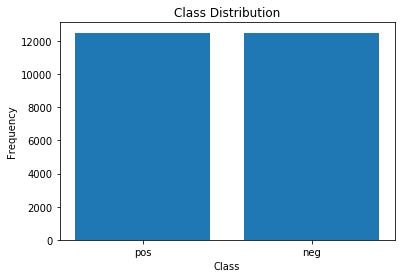

In [2]:
import os, os.path

pos = 'aclImdb/train/pos'
count_pos = len([name for name in os.listdir(pos) if os.path.isfile(os.path.join(pos, name))])
print(count_pos)
neg = 'aclImdb/train/neg'
count_neg = len([name for name in os.listdir(neg) if os.path.isfile(os.path.join(neg, name))])
print(count_neg)
plt.bar(['pos', 'neg'], [count_pos, count_neg])

plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### create datasets using text_dataset_from_directory

In [3]:
batch_size = 64
train = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)

validation = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)

test = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(
    "Number of batches in train: %d"
    % tf.data.experimental.cardinality(train)
)
print(
    "Number of batches in validation: %d" % tf.data.experimental.cardinality(validation)
)
print(
    "Number of batches in test: %d"
    % tf.data.experimental.cardinality(test)
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in train: 313
Number of batches in validation: 79
Number of batches in test: 391


In [4]:
tf.random.set_seed(123)
for text_batch, label_batch in train.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see on the big screen, because even in a widescreen presentation, I don\'t think the overall scope of this film would receive its

### Data preparation

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

# remove <br />
def custom_standardization(data):
    lowercase = tf.strings.lower(data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html,
                                    "[%s]" % re.escape(string.punctuation),
                                    "")

max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = TextVectorization(
                    standardize=custom_standardization,
                    max_tokens=max_features,
                    output_mode='int',
                    output_sequence_length=sequence_length
                  )

text = train.map(lambda x, y: x)
vectorize_layer.adapt(text)

Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs.

In [6]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label
    
# vectorize
train_ds = train.map(vectorize_text)
validation_ds = validation.map(vectorize_text)
test_ds = test.map(vectorize_text)

In [7]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(2):
        print(text_batch.numpy()[i].shape)
        print(text_batch.numpy()[i])
        print("label : ", label_batch.numpy()[i]) 

(500,)
[   11  1600    10   506    17     2   239   102    11    25   121   107
    11   252     4  3550  1470   766    97    25   222     4   123   278
     2   418    19    11    25   121   107     3    11    25   107    46
    79   513   154   610   539    11  1456  8762     6   881     9     3
    12    13     1    99    72     2   112     7   506     2   101    24
   418     3     2    19     7    41     4   402     5  1194     2     1
   314   135    24    37   486   413    12     9   155     4  1010     1
   164    38    33   793  5861    31    11    68   130     7    44    22
     1     6   415     4    49  2100     3     4   111   273   137   881
    10   506   503    11    59   237   103   453 16096    36  4458   821
   132  1242     8     4  9663     5 18606    70   850   139    10  4037
   170     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0  

### Build the model

In [8]:
from tensorflow.keras import layers, Input

inputs = Input(shape=(None,), dtype="int64")

x = layers.Embedding(max_features, embedding_dim)(inputs)
y = layers.Dropout(0.5)(x)

x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [10]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=3)

Epoch 1/3
313/313 [==============================] - 77s 243ms/step - loss: 0.6263 - accuracy: 0.5844 - val_loss: 0.3092 - val_accuracy: 0.8692
Epoch 2/3
313/313 [==============================] - 57s 181ms/step - loss: 0.2717 - accuracy: 0.8899 - val_loss: 0.3917 - val_accuracy: 0.8622
Epoch 3/3
313/313 [==============================] - 57s 182ms/step - loss: 0.0977 - accuracy: 0.9647 - val_loss: 0.4910 - val_accuracy: 0.8728


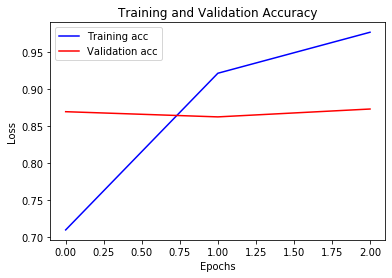

In [11]:
def visualize_loss(history, title):
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training acc")
    plt.plot(epochs, val_loss, "r", label="Validation acc")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Accuracy")

In [12]:
model.evaluate(test_ds)

391/391 [==============================] - 34s 85ms/step - loss: 0.5189 - accuracy: 0.8622


[0.5189278721809387, 0.8621600270271301]

### End to end model with strings as inputs

In [13]:
inputs = Input(shape=(1,), dtype="string")
indices = vectorize_layer(inputs)
outputs = model(indices)

end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(loss="binary_crossentropy",
                         optimizer="adam", metrics=["accuracy"])

end_to_end_model.evaluate(test)

391/391 [==============================] - 17s 41ms/step - loss: 0.5249 - accuracy: 0.8620


[0.518927812576294, 0.8621600270271301]

In [14]:
prediction = end_to_end_model.predict(test, verbose=1)

391/391 [==============================] - 16s 39ms/step
